In [1]:
import numpy as np
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [6]:
# df['model'] = 'ground_truth'
# data = pd.read_csv('../../data_sprint_2025/dengue.csv.gz')
data = pd.read_parquet('../../ds-spatiotemporal-mosqlimate/data/03_primary/dataset_complete_dengue_uf.parquet')
data = data.groupby(['date','epiweek', 'uf', 'train_1', 'target_1', 'train_2', 'target_2', 'train_3', 'target_3'])['casos'].sum().reset_index()
data.rename(columns={'casos': 'target'}, inplace=True)

In [7]:
train_1 = data[data['train_1']][['uf','date','target']]
train_1 = TimeSeriesDataFrame.from_data_frame(train_1,id_column='uf',timestamp_column='date')

test_1  = data[data['target_1']][['uf','date','target']]
test_1 = TimeSeriesDataFrame.from_data_frame(test_1,id_column='uf',timestamp_column='date')


train_2 = data[data['train_2']][['uf','date','target']]
train_2 = TimeSeriesDataFrame.from_data_frame(train_2,id_column='uf',timestamp_column='date')
test_2  = data[data['target_2']][['uf','date','target']]
test_2 = TimeSeriesDataFrame.from_data_frame(test_2,id_column='uf',timestamp_column='date')

train_3 = data[data['train_3']][['uf','date','target']]
train_3 = TimeSeriesDataFrame.from_data_frame(train_3,id_column='uf',timestamp_column='date')
test_3 = data[data['target_3']][['uf','date','target']]
test_3 = TimeSeriesDataFrame.from_data_frame(test_3,id_column='uf',timestamp_column='date')


In [8]:
end_1 = np.array(data[data['train_1']].sort_values(by='date')['epiweek'])[-1]
init_2 = np.array(data[data['target_1']].sort_values(by='date')['epiweek'])[0]

prediction_length = (init_2 - end_1) + test_1.reset_index()[test_1.reset_index()['item_id'] == 'CE'].shape[0]

In [9]:
prediction_length

68

In [10]:
# QS = [0.05,0.1,0.2,0.5,0.8,0.9,0.95]
# prediction_length = 16 + 52
predictor = TimeSeriesPredictor(
    prediction_length=prediction_length,
    # quantile_levels=QS
).fit(
    train_1, presets="bolt_tiny",
)

Beginning AutoGluon training...
AutoGluon will save models to '/Users/davibarreira/Documents/DSProjects/Mosqlimate/jbd-mosqlimate-sprint/notebooks/AutogluonModels/ag-20250717_181211'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.11
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.5.0: Tue Apr 22 19:54:33 PDT 2025; root:xnu-11417.121.6~2/RELEASE_ARM64_T8122
CPU Count:          8
GPU Count:          0
Memory Avail:       3.67 GB / 16.00 GB (22.9%)
Disk Space Avail:   390.52 GB / 926.35 GB (42.2%)
Setting presets to: bolt_tiny

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_tiny'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 68,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_mode

In [11]:
predictions = predictor.predict(train_1)

Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_tiny]


data with frequency 'IRREG' has been resampled to frequency 'W-SUN'.


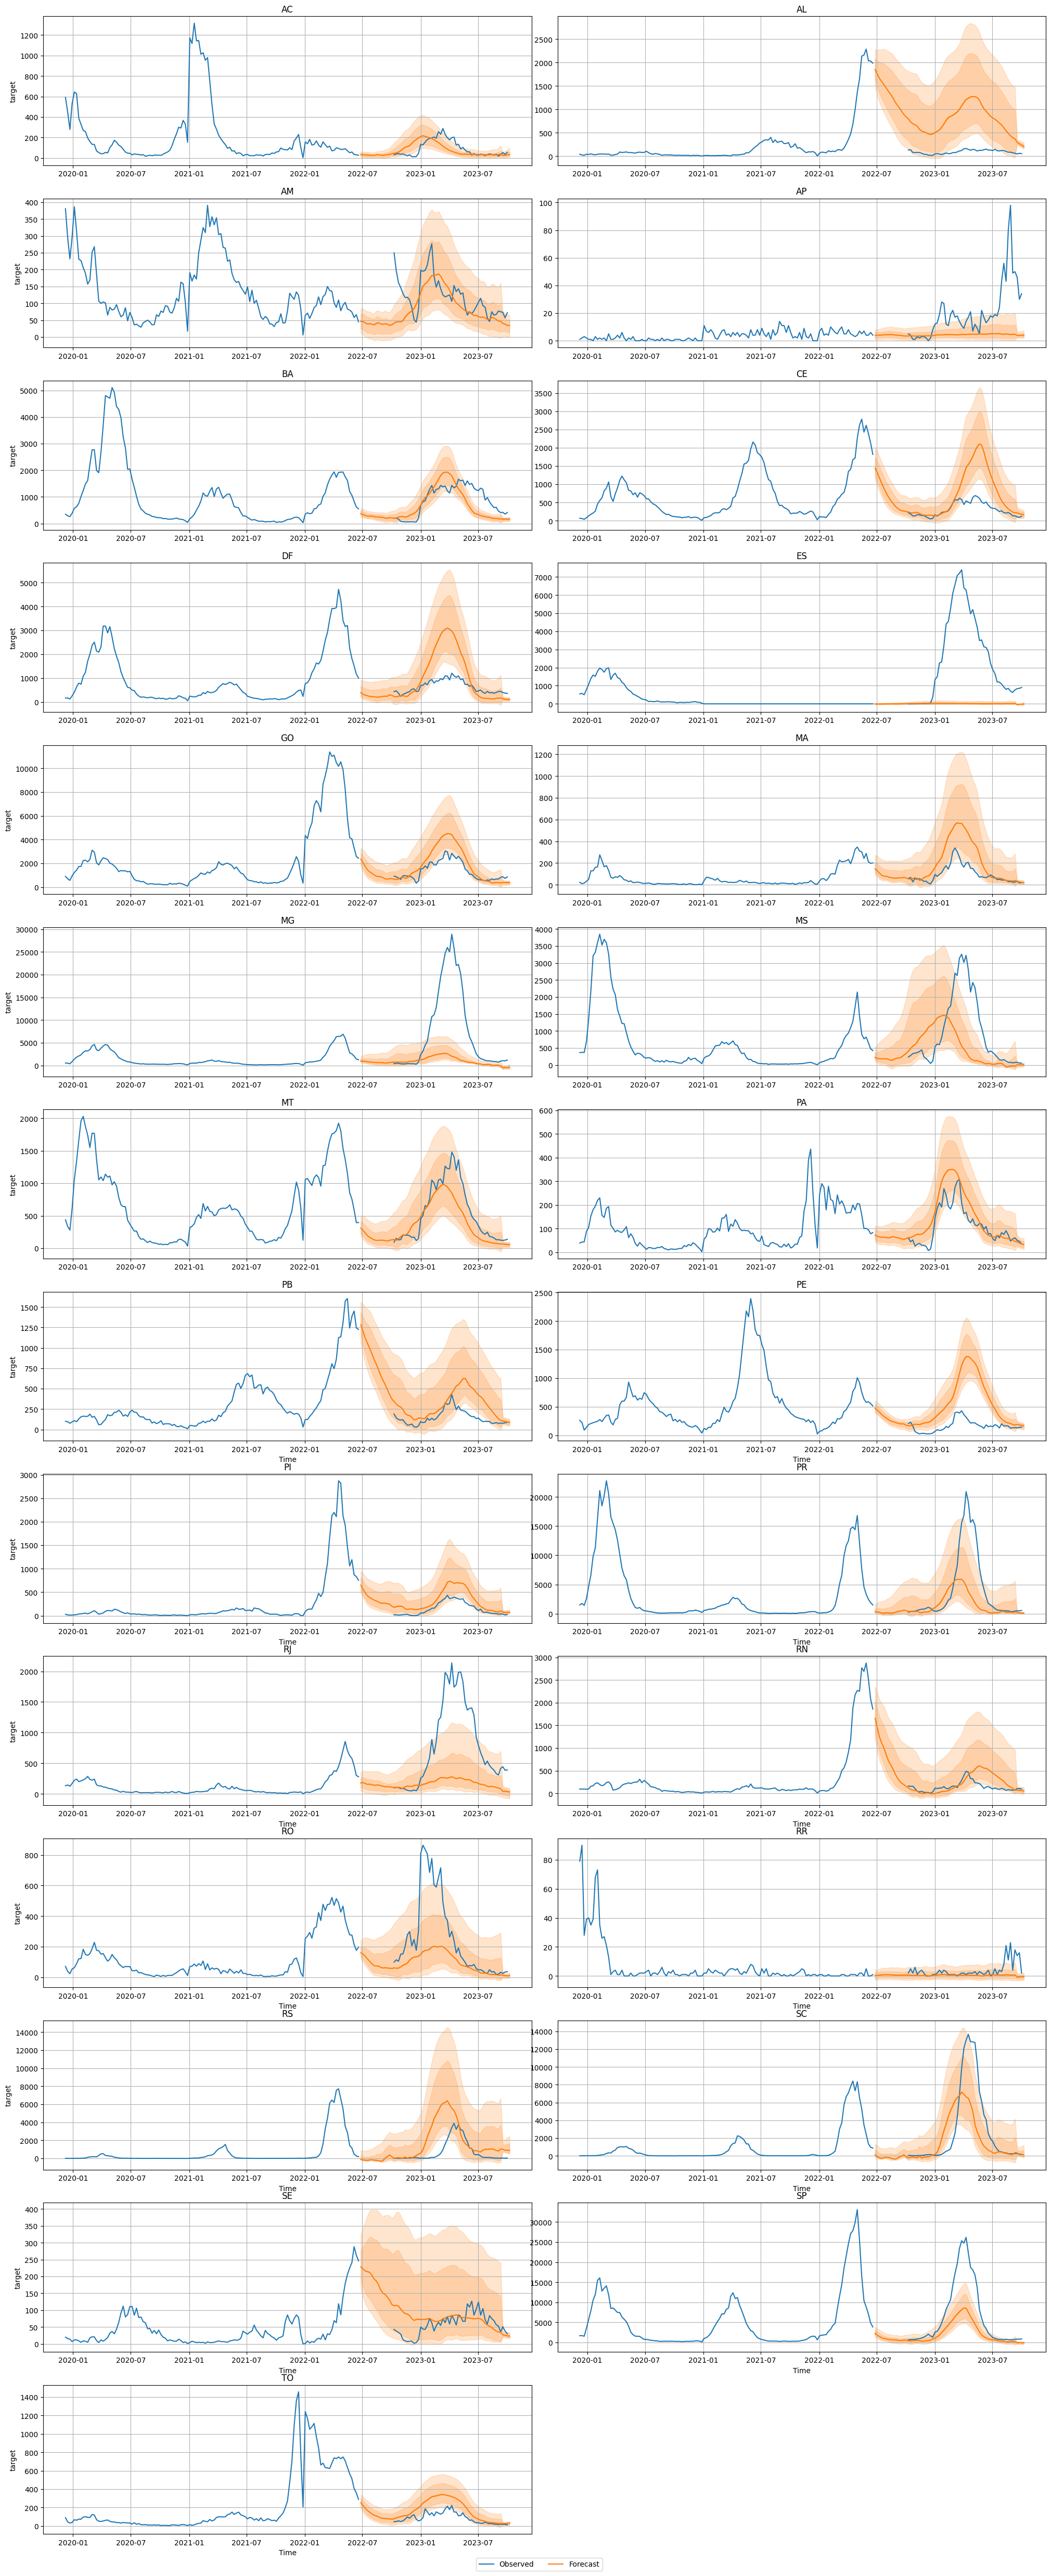

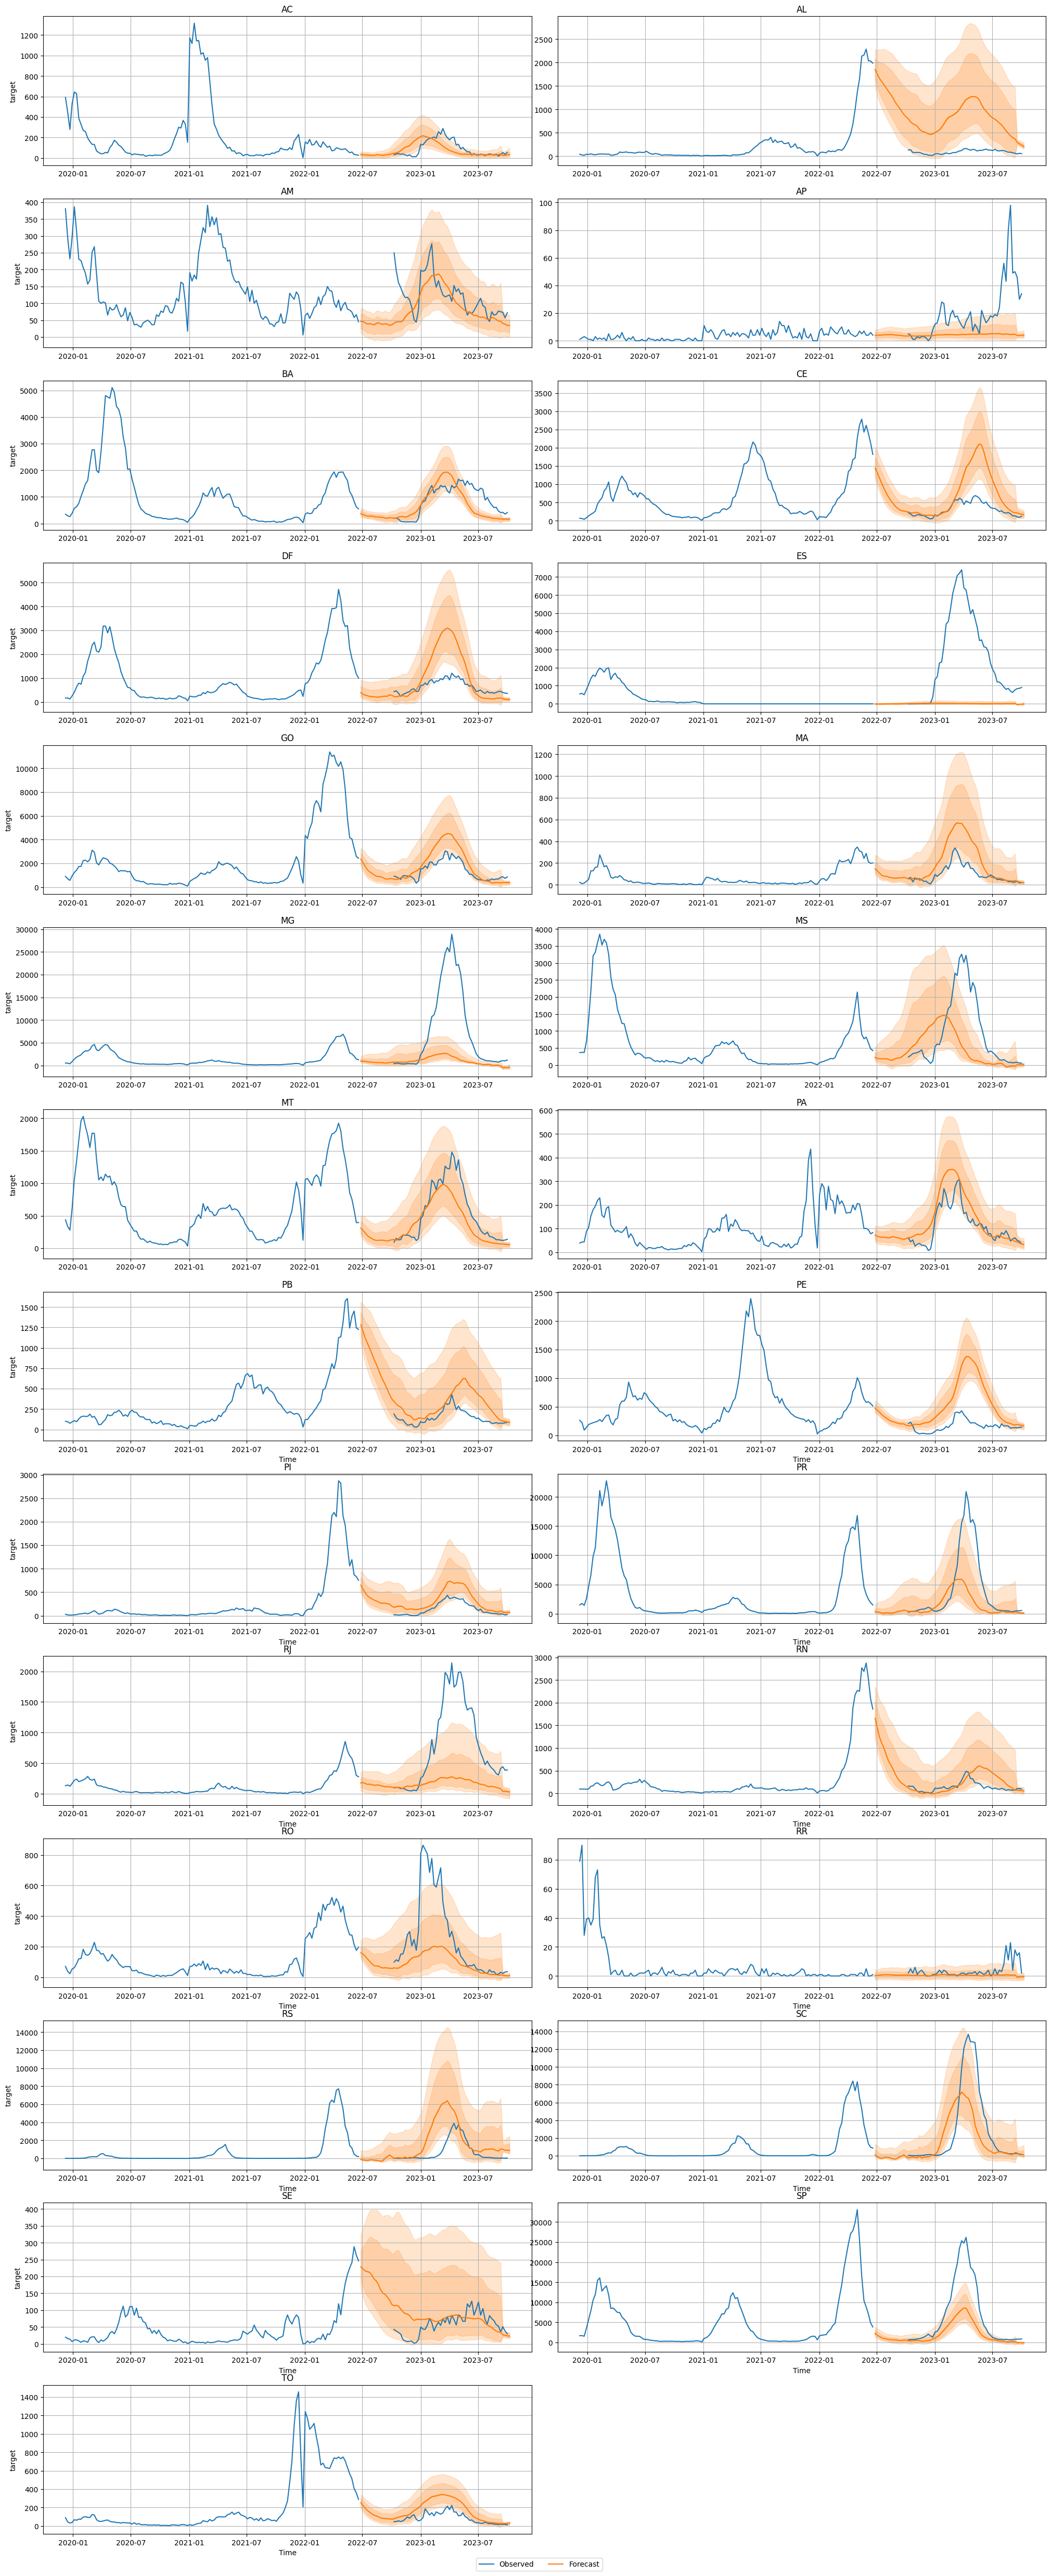

In [12]:
ufs = pd.unique(data['uf'])
predictor.plot(
    data=pd.concat([train_1,test_1]),
    quantile_levels=[0.1,0.2,0.5,0.8,0.9],
    # quantile_levels=[0.05,0.1,0.5,0.9,0.95],
    # quantile_levels= QS,
    predictions=predictions,
    # item_ids=['CE'],
    item_ids = ufs,
    max_num_item_ids=None,
    max_history_length=200,
)

In [17]:
# predictions.reset_index().to_csv('./pre')

In [20]:
predictions.to_parquet('../predictions/autogluon_baseline.parquet')